# Countryrisk

In [1]:
import wbdata
import pandas as pd
import pandas_profiling
import datetime
import quandl
%config IPCompleter.greedy=True
import pandas_datareader
import urllib3


# 1- Extracting and Cleaning the Data from IMF, WB and BIS

## Country selection


In [2]:
### fecthing country names from IMF database to get all ISO codes
countrycodes = pd.read_csv('coucodes.csv', delimiter = ';', encoding = "ISO-8859-1")
countrycodes = countrycodes[["IMF Name", "ISO Code", "ISO2 Code"]]
countrycodes.reset_index(level=0, inplace=True)
countrycodes = countrycodes.rename(columns={'IMF Name': 'country'})

countries = ["Brazil",  "Mexico", "India",  "Russia", "Uruguay",
             "Korea", "Thailand", "Costa Rica", "Colombia", "Paraguay",
             "Chile", "South Africa", "Taiwan", "Turkey", "Ukraine", "Nigeria", "Indonesia",
             "Bangladesh", "Philippines", "Pakistan", "Egypt", "Ethiopia", "Vietnam", 
             "Myanmar", "Algeria", "Sudan", "Uganda", "Morocco",  "Malaysia",
             "Afghanistan", "Ghana", "Laos", "Singapore", "Poland",
             "Israel", "Czech Republic", "Romania", "Hungary", "Kazakhstan", "Kenya", "Angola",
            "Dominican Republic", "Sri Lanka", "Guatemala", "Bulgaria", "Tanzania", "Belaurus",
            "Croatia",  "Democratic Republic of the Congo",
            "Azerbaijan", "Côte d'Ivoire", "Argentina", "Iran", "Iraq", "Venezuela"]

countrycodes2 = countrycodes.copy()
countrycodes2 = countrycodes2[["country", "ISO2 Code"]]
countrycodes2 = countrycodes2.dropna()

#Argentina, Australia,  Venezuela e Iraq are not working - Monthly
#
countrycodes = countrycodes[countrycodes["country"].isin(countries)]

In [3]:
from datetime import datetime
from itertools import product

today = datetime.today()
datem = datetime(today.year, today.month, 1)

year = pd.date_range('1995-01-01', end = str(today.month-2) + "-" + str(today.year), freq='MS').strftime('%Y-%m')


base = pd.DataFrame(data=list(product(year, countrycodes["ISO2 Code"])), columns=['year','ISO2 Code'])
base = base.sort_values(by=['ISO2 Code', "year"]).dropna()


## WB


In [4]:
#downloading data from worldbank

from pandas_datareader import wb

worldbank_data = pandas_datareader.wb.download(indicator = ["DSTKMKTXD"], country = countrycodes["ISO Code"], start = 2010, end = 2020, freq = "M")
worldbank_data2 = pandas_datareader.wb.download(indicator =["DSTKMKTXD"], country = countrycodes["ISO Code"], start = 1999, end = 2009, freq = "M")
worldbank_data3 = pandas_datareader.wb.download(indicator = ["DSTKMKTXD"], country = countrycodes["ISO Code"], start = 1990, end = 1998, freq = "M")

worldbank_data = pd.concat([worldbank_data, worldbank_data2])
worldbank_data = pd.concat([worldbank_data, worldbank_data3])

worldbank_data.reset_index(inplace=True)

worldbank_data_conc = pd.merge(worldbank_data, countrycodes, on="country")
worldbank_data_conc["year"] = pd.to_datetime(worldbank_data_conc["year"], format='%YM%m')
worldbank_data_conc.drop(["country", "ISO Code", "index"],1, inplace = True)


## IMF

In [5]:
#Run R script to import imf data - R package makes the task much easier

import subprocess
retcode = subprocess.call(['C:/Program Files/R/R-3.5.1/bin/Rscript.exe', '--vanilla', 
                           'C:/Users/vitor/OneDrive/Documentos/databowl/teste.R'])

In [6]:
stack = pd.read_csv("teste2.csv")
stack =stack.rename(columns = {'x_gdp':'PCTOT', "iso2c": "ISO2 Code", "year_month": "year"})
stack.drop("Unnamed: 0", inplace = True, axis = 1)
stack["year"] = pd.to_datetime(stack["year"], format='%Y-%m')


In [7]:
stack.columns

Index(['ISO2 Code', 'year', 'FM2_XDC', 'RAXGFX_USD', 'LUR_PT', 'TXG_FOB_USD',
       'TMG_CIF_USD', 'FDSAOP_XDC', 'AIP_IX', 'ENDE_XDC_USD_RATE', 'FMB_XDC',
       'FIMM_PA', 'EREER_IX', 'FILR_PA', 'FISR_PA', 'FDSF_XDC', 'FDSB_XDC',
       'RAXG_USD', 'PCPI_IX', 'FASMB_XDC', 'PCTOT', 'NGDP_XDC', 'BGS_BP6_USD',
       'BCAXF_BP6_USD'],
      dtype='object')

## OECD

In [140]:
full = pd.merge(stack, worldbank_data_conc, left_on = ["ISO2 Code", "year"], right_on = ["ISO2 Code", "year"], how = "left")


## Couprisk

In [141]:
from bs4 import BeautifulSoup, SoupStrainer
import requests
import re

url = "https://oefdatascience.github.io/REIGN.github.io/menu/reign_current.html"

page = requests.get(url)    
data = page.text
soup = BeautifulSoup(data)

links = []
for link in soup.find_all(attrs={'href': re.compile("http")}):
    links.append(link.get('href'))


sub = "https://cdn.rawgit.com/OEFDataScience/REIGN.github.io/gh-pages/data_sets/REIGN"


link = [word for word in links if word.startswith(sub)]

import pandas as pd
couprisk = pd.read_csv(link[0])
couprisk = couprisk[["country", "year", "month", "couprisk", "ccode"]]
couprisk["month"] = couprisk["month"].astype(int)
couprisk["month"] = couprisk.month.map("{:02}".format)
couprisk["year"] = couprisk["year"].round().astype(int).astype(str) + "-" + couprisk["month"].astype(str)+"-" + "01"



In [142]:
cowcode = pd.read_csv("coucodes2.csv", sep = ";")
cowcode = cowcode.drop_duplicates()

#couprisk = couprisk[couprisk["country"].isin(countries)]
couprisk = pd.merge(couprisk, cowcode, left_on = "ccode", right_on = "cowcode2")

couprisk = couprisk.drop(["country", "ccode", "cowcode2"], 1)
couprisk = couprisk.drop_duplicates(["year", "ccdcodelet"])
couprisk = couprisk.rename(columns={'ccdcodelet': 'ISO Code'})
couprisk = pd.merge(couprisk, countrycodes, on = "ISO Code")
couprisk = couprisk.drop(["index", "ISO Code", "country"], 1)


In [143]:
from bs4 import BeautifulSoup, SoupStrainer
import requests
import re

url = "https://oefdatascience.github.io/REIGN.github.io/menu/reign_current.html"

page = requests.get(url)    
data = page.text
soup = BeautifulSoup(data)

links = []
for link in soup.find_all(attrs={'href': re.compile("http")}):
    links.append(link.get('href'))


sub = "https://cdn.rawgit.com/OEFDataScience/REIGN.github.io/gh-pages/data_sets/electionlist"


link = [word for word in links if word.startswith(sub)]

import pandas as pd
election = pd.read_csv(link[0])
election = election[["country", "elec_year", "ccode", "elec_month"]]
election["elec_month"] = election["elec_month"].fillna(1).astype(int)
election["elec_month"] = election.elec_month.map("{:02}".format)
election["elec_year"] = election["elec_year"].round().astype(int).astype(str) + "-" + election["elec_month"].astype(str)+"-" + "01"


In [144]:
election = pd.merge(election, cowcode, left_on = "ccode", right_on = "cowcode2")

election = election.drop(["country", "ccode", "cowcode2"], 1)
#election = election.drop_duplicates(["year", "ccdcodelet"])
election = election.rename(columns={'ccdcodelet': 'ISO Code', "elec_year" : "year"})
election = pd.merge(election, countrycodes, on = "ISO Code")
election = election.drop(["index", "ISO Code", "country", "elec_month"], 1)
election["election"] = 1
election = election.drop_duplicates()

In [145]:
couprisk["year"] = pd.to_datetime(couprisk["year"], errors = "coerce")
election["year"] = pd.to_datetime(election["year"], errors = "coerce")


full = pd.merge(full, couprisk, on = ["ISO2 Code", "year"], how = "left")
full = pd.merge(full, election, on = ["ISO2 Code", "year"], how = "left")

full["election"] = full["election"].fillna(0)
full = full[full["ISO2 Code"] != "RO"]
full = full[full["ISO2 Code"] != "BH"]
full = full[full.year.notnull()]

In [146]:
GGXWDG_NGDP = pd.read_csv("GGXWDG_NGDP.csv", error_bad_lines=False, sep = ";")
GGXWDG_NGDP = pd.melt(GGXWDG_NGDP, id_vars=['country'])
GGXWDG_NGDP = pd.merge(GGXWDG_NGDP, countrycodes2, on = "country", how = "left")
GGXWDG_NGDP = GGXWDG_NGDP.dropna()
GGXWDG_NGDP["variable"] = pd.to_datetime(GGXWDG_NGDP["variable"], errors = "coerce")
GGXWDG_NGDP = GGXWDG_NGDP.rename(columns = {"value": "GGXWDG_NGDP", "variable" : "year"})

GGXCNL_NGDP = pd.read_csv("GGXCNL_NGDP.csv", error_bad_lines=False, sep = ";")
GGXCNL_NGDP = pd.melt(GGXCNL_NGDP, id_vars=['country'])
GGXCNL_NGDP = pd.merge(GGXCNL_NGDP, countrycodes2, on = "country", how = "left")
GGXCNL_NGDP = GGXCNL_NGDP.dropna()
GGXCNL_NGDP["variable"] = pd.to_datetime(GGXCNL_NGDP["variable"], errors = "coerce")
GGXCNL_NGDP = GGXCNL_NGDP.rename(columns = {"value": "GGXCNL_NGDP", "variable" : "year"})

full = pd.merge(full, GGXWDG_NGDP, on = ["ISO2 Code", "year"], how = "left")
full =pd.merge(full,  GGXCNL_NGDP, on = ["ISO2 Code", "year"], how = "left")

full = full.drop(["country_x", "country_y"],1)

In [147]:
import yfinance as yf

msft = yf.Ticker("^VIX")
vix = msft.history(period="max")


In [148]:
import quandl
quandl.ApiConfig.api_key = "e2KZ8SFfstro3DH2_zvj"

oil = quandl.get("ODA/POILWTI_USD")
oil.index = oil.index + pd.offsets.MonthBegin(0)
oil.reset_index(inplace = True)
oil = oil.rename(columns = {"Date": "year", "Value":"oil"})
full = pd.merge(full, oil, on = "year", how = "left")

In [149]:
full

,ISO2 Code,year,FM2_XDC,RAXGFX_USD,LUR_PT,TXG_FOB_USD,TMG_CIF_USD,FDSAOP_XDC,AIP_IX,ENDE_XDC_USD_RATE,...,NGDP_XDC,BGS_BP6_USD,BCAXF_BP6_USD,DSTKMKTXD,month,couprisk,election,GGXWDG_NGDP,GGXCNL_NGDP,oil
0,AE,1990-01-01,NaN,4095.800000,NaN,NaN,958.594388,NaN,NaN,3.6710,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,21.130000
1,AE,1990-02-01,NaN,4236.300000,NaN,NaN,846.635794,NaN,NaN,3.6710,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,22.960000
2,AE,1990-03-01,NaN,4367.600000,NaN,NaN,1014.982294,NaN,NaN,3.6710,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,22.120000
3,AE,1990-04-01,NaN,4253.000000,NaN,NaN,947.425770,NaN,NaN,3.6710,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,20.410000
4,AE,1990-05-01,NaN,4246.000000,NaN,NaN,1113.320621,NaN,NaN,3.6710,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,18.430000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74817,ZW,2019-06-01,NaN,179.397856,NaN,NaN,NaN,5128.717217,NaN,6.6220,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,60.733478
74818,ZW,2019-07-01,NaN,131.688295,NaN,NaN,NaN,5545.475996,NaN,9.1856,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,54.677000
74819,ZW,2019-08-01,NaN,174.810935,NaN,NaN,NaN,6099.787635,NaN,10.7139,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,57.508696
74820,ZW,2019-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,54.839091


In [150]:
#vix
vix.sort_index(inplace=True)
vix2 = vix.copy()
vix2.index = pd.to_datetime(vix2.index) + pd.offsets.MonthBegin(0)
vix2 = vix2["Open"].to_frame()
vix2 = vix2.loc[~vix2.index.duplicated(keep='first')]
vix2.reset_index(inplace = True)
vix2 = vix2.rename(columns = {"Date": "year", "Open":"vix"})

full = pd.merge(full, vix2, on = "year", how = "left")


In [151]:
currency = full.sort_values(by=['year']).copy()


In [152]:
full = full[full["ISO2 Code"].isin(countrycodes["ISO2 Code"])]

# 2 - Creating variables and cleaning the Data

In [153]:


#to numeric
cols = full.columns.drop(["ISO2 Code", "year"])

full[cols] = full[cols].apply(pd.to_numeric, errors='coerce')

In [154]:
import numpy as np
teste = full.copy()
teste.set_index(["year", "ISO2 Code"], inplace = True)
teste[cols] = teste[cols].apply(pd.to_numeric, errors='coerce')
teste = teste.notnull().astype('int')
teste.reset_index(inplace = True)
teste.set_index("year", inplace = True)
teste.replace(0, np.nan, inplace=True)
teste.reset_index(inplace = True)

In [155]:
#teste = pd.merge(countrycodes2, teste, how = "left", on = "ISO2 Code")
#teste.set_index("year", inplace = True)
#teste.groupby("country").idxmax().to_csv("first.csv")

In [156]:
#teste = teste.iloc[::-1]
#teste.groupby("country").idxmax().to_csv("last.csv")

In [157]:
#Counting missing values by country
#full2 = full
#full2 = pd.merge(countrycodes2, full2, how = "right", on = "ISO2 Code")
#g = full2.groupby('country')
#g.count().rsub(g.size(), axis=0).to_csv("missings.csv")

In [158]:
full

,ISO2 Code,year,FM2_XDC,RAXGFX_USD,LUR_PT,TXG_FOB_USD,TMG_CIF_USD,FDSAOP_XDC,AIP_IX,ENDE_XDC_USD_RATE,...,BGS_BP6_USD,BCAXF_BP6_USD,DSTKMKTXD,month,couprisk,election,GGXWDG_NGDP,GGXCNL_NGDP,oil,vix
358,AF,1990-01-01,NaN,237.69,NaN,NaN,NaN,NaN,NaN,42.822780,...,NaN,NaN,NaN,1.0,0.006652,0.0,NaN,NaN,21.130000,NaN
359,AF,1990-02-01,NaN,236.53,NaN,NaN,NaN,NaN,NaN,42.822780,...,NaN,NaN,NaN,2.0,0.007486,0.0,NaN,NaN,22.960000,17.24
360,AF,1990-03-01,NaN,221.15,NaN,NaN,NaN,NaN,NaN,42.822780,...,NaN,NaN,NaN,3.0,0.006268,0.0,NaN,NaN,22.120000,24.32
361,AF,1990-04-01,NaN,232.30,NaN,NaN,NaN,NaN,NaN,42.822780,...,NaN,NaN,NaN,4.0,0.009069,0.0,NaN,NaN,20.410000,21.34
362,AF,1990-05-01,NaN,239.44,NaN,NaN,NaN,NaN,NaN,42.822780,...,NaN,NaN,NaN,5.0,0.008204,0.0,NaN,NaN,18.430000,22.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74101,ZA,2019-06-01,NaN,41126.00,NaN,NaN,NaN,3.311406e+06,NaN,14.170307,...,NaN,NaN,107.654577,6.0,0.000840,0.0,NaN,NaN,60.733478,14.35
74102,ZA,2019-07-01,NaN,40582.00,NaN,NaN,NaN,3.317109e+06,NaN,14.236456,...,NaN,NaN,110.850581,7.0,0.000888,0.0,NaN,NaN,54.677000,19.41
74103,ZA,2019-08-01,NaN,40794.00,NaN,NaN,NaN,3.348591e+06,NaN,15.241997,...,NaN,NaN,97.281530,8.0,0.000910,0.0,NaN,NaN,57.508696,14.16
74104,ZA,2019-09-01,NaN,45908.00,NaN,NaN,NaN,3.361983e+06,NaN,15.208940,...,NaN,NaN,100.334804,9.0,0.000936,0.0,NaN,NaN,54.839091,17.69


In [159]:
#to numeric
cols = full.columns.drop(["ISO2 Code", "year"])

full[cols] = full[cols].apply(pd.to_numeric, errors='coerce')



In [160]:
#creation
full["broad_reserves_ratio"] = full["FDSB_XDC"]/(full["RAXG_USD"]*full["ENDE_XDC_USD_RATE"]).diff(1)
full["broad_base_ratio"] = full["FDSB_XDC"]/full["FASMB_XDC"].diff(1)
full["foreignassets_reserves_ratio"] = full["FDSF_XDC"]/(full["RAXG_USD"]*full["ENDE_XDC_USD_RATE"]).diff(1)

full["inflation"] = full.groupby('ISO2 Code', sort=False).PCPI_IX.apply(
     lambda x: x.pct_change(12))

full["BCAXF_BP6_USD"] = full["BCAXF_BP6_USD"]*full["ENDE_XDC_USD_RATE"]/full["NGDP_XDC"]


full["current_account"] = full.groupby('ISO2 Code', sort=False).BCAXF_BP6_USD.apply(
     lambda x: x.pct_change(12)) 

full["moneymarket_rate"] = full.groupby('ISO2 Code', sort=False).FIMM_PA.apply(
     lambda x: x.pct_change(12))

full["reserves"] = full["RAXG_USD"].diff(1)
full["reserves_12p"] = full.groupby('ISO2 Code', sort=False).RAXG_USD.apply(
     lambda x: x.pct_change(12))

full["stocks"] = full.groupby('ISO2 Code', sort=False).DSTKMKTXD.apply(
     lambda x: x.pct_change(12))

full["commodities_index"] =  full.groupby('ISO2 Code', sort=False).PCTOT.apply(
     lambda x: x.pct_change(12))  

full["exports"] = full.groupby('ISO2 Code', sort=False).TXG_FOB_USD.apply(
     lambda x: x.pct_change(12))

full["imports"] = full.groupby('ISO2 Code', sort=False).TMG_CIF_USD.apply(
     lambda x: x.pct_change(12))

full["imports_fx"] = (full["TMG_CIF_USD"]/full["RAXG_USD"]).diff(1)

full["exchange_change"] = full.groupby('ISO2 Code', sort=False).ENDE_XDC_USD_RATE.apply(
     lambda x: x.pct_change(1)).shift(1)

full["exchange_change_12m"] = full.groupby('ISO2 Code', sort=False).ENDE_XDC_USD_RATE.apply(
     lambda x: x.pct_change(12))

full["net_debt"] = full.groupby('ISO2 Code', sort=False).GGXWDG_NGDP.apply(
     lambda x: x.pct_change(12))

full["lending_borrowing"] = full.groupby('ISO2 Code', sort=False).GGXCNL_NGDP.apply(
     lambda x: x.pct_change(12))

full["lending_rate"] = full.groupby('ISO2 Code', sort=False).FILR_PA.apply(
     lambda x: x.pct_change(12))

full["M2"] = full.groupby('ISO2 Code', sort=False).FM2_XDC.apply(
     lambda x: x.pct_change(12))

full["claims_private"] = full.groupby('ISO2 Code', sort=False).FDSAOP_XDC.apply(
     lambda x: x.pct_change(12)).diff(1)

full["vix"] = full.groupby('ISO2 Code', sort=False).vix.apply(
     lambda x: x.pct_change(12))

full["oil"] = full.groupby('ISO2 Code', sort=False).oil.apply(
     lambda x: x.pct_change(12))


full["lag_1"] =full.groupby("ISO2 Code")["election"].shift(-1).fillna(0)
full["lag_2"] =full.groupby("ISO2 Code")["election"].shift(-2).fillna(0)
full["lag_3"] =full.groupby("ISO2 Code")["election"].shift(-3).fillna(0)
full["lag_4"] =full.groupby("ISO2 Code")["election"].shift(-4).fillna(0)
full["lag_5"] =full.groupby("ISO2 Code")["election"].shift(-5).fillna(0)
full["lag_6"] =full.groupby("ISO2 Code")["election"].shift(-6).fillna(0)
full['election_p'] =  full["lag_1"] + full["lag_2"] + full["lag_3"] + full["lag_4"] + full["lag_5"] + full["lag_6"]
full['election_p'] = np.where(full['election_p'] > 0, 1, 0)

full["lag_1"] =full.groupby("ISO2 Code")["election"].shift(1).fillna(0)
full["lag_2"] =full.groupby("ISO2 Code")["election"].shift(2).fillna(0)
full["lag_3"] =full.groupby("ISO2 Code")["election"].shift(3).fillna(0)
full["lag_4"] =full.groupby("ISO2 Code")["election"].shift(4).fillna(0)
full["lag_5"] =full.groupby("ISO2 Code")["election"].shift(5).fillna(0)
full["lag_6"] =full.groupby("ISO2 Code")["election"].shift(6).fillna(0)
full['election'] =  full["lag_1"] + full["lag_2"] + full["lag_3"] + full["lag_4"] + full["lag_5"] + full["lag_6"]
full['election'] = np.where(full['election'] > 0, 1, 0)


#full["exchange_change"] = full.groupby('ISO2 Code', sort=False).ENDE_XDC_USD_RATE.apply(
     #lambda x: x.pct_change(12))

full.drop(["FASMB_XDC", "FDSB_XDC", "FDSF_XDC", "FIMM_PA",  "PCPI_IX", "RAXG_USD", "PCTOT",
           "BCAXF_BP6_USD", "DSTKMKTXD", "FILR_PA", "GGXCNL_NGDP", "GGXWDG_NGDP", "TXG_FOB_USD", "TMG_CIF_USD",
          "LUR_PT", "FDSAOP_XDC", "AIP_IX", "EREER_IX", "BGS_BP6_USD", "NGDP_XDC", "FM2_XDC", "RAXGFX_USD",
          "FMB_XDC", "FISR_PA", "lag_1", "lag_2", "lag_3", "lag_4", 'lag_5', "lag_6"],1, inplace = True)                                                         

In [161]:
full.set_index(["year", "ISO2 Code"], inplace = True)

#full = full.groupby(level=1).ffill()
full = full.replace([np.inf, -np.inf], np.nan)


In [162]:
full.exchange_change = full.exchange_change.fillna(0)


In [163]:
#Dropping columns used to create the new variables
#Scaling

#full["ISO"] = full.index.get_level_values(1)
#full = pd.get_dummies(full, columns=['ISO'], prefix = ['Country'])

# Definition of dependent variable

In [164]:
import numpy as np
full_fill = full
#FIRST DEFINITION
full_fill["dummy"] = np.where(full_fill['exchange_change']  >0.20, 1, 0) #10 percent variation

#SECOND DEFINITION
#full_fill["threshold"] = full_fill.groupby("ISO2 Code")["exchange_change"].transform("mean") + (full_fill.groupby("ISO2 Code")["exchange_change"].transform("std"))
#full_fill["dummy"] = np.where(full_fill['exchange_change'] > full_fill["threshold"], 1, 0) # > 2 stdev threshold

#THIRD DEFINITION
#full_fill["dummy"] = np.where(full_fill['exchange_change_12m'].shift(-6) >0.2, 1, 0) #50 percent variation in the next 12 months


crise = full_fill

crise["lag_1"] =crise.groupby("ISO2 Code")["dummy"].shift(-1).fillna(0)
crise["lag_2"] =crise.groupby("ISO2 Code")["dummy"].shift(-2).fillna(0)
crise["lag_3"] =crise.groupby("ISO2 Code")["dummy"].shift(-3).fillna(0)
crise["lag_4"] =crise.groupby("ISO2 Code")["dummy"].shift(-4).fillna(0)
crise["lag_5"] =crise.groupby("ISO2 Code")["dummy"].shift(-5).fillna(0)
crise["lag_6"] =crise.groupby("ISO2 Code")["dummy"].shift(-6).fillna(0)
crise["lag_7"] =crise.groupby("ISO2 Code")["dummy"].shift(-7).fillna(0)
crise["lag_8"] =crise.groupby("ISO2 Code")["dummy"].shift(-8).fillna(0)
crise["lag_9"] =crise.groupby("ISO2 Code")["dummy"].shift(-9).fillna(0)
crise["lag_10"] =crise.groupby("ISO2 Code")["dummy"].shift(-10).fillna(0)
crise["lag_11"] =crise.groupby("ISO2 Code")["dummy"].shift(-11).fillna(0)
crise["lag_12"] =crise.groupby("ISO2 Code")["dummy"].shift(-12).fillna(0)
crise["lag_13"] =crise.groupby("ISO2 Code")["dummy"].shift(-13).fillna(0)
crise["lag_14"] =crise.groupby("ISO2 Code")["dummy"].shift(-14).fillna(0)
crise["lag_15"] =crise.groupby("ISO2 Code")["dummy"].shift(-15).fillna(0)
crise["lag_16"] =crise.groupby("ISO2 Code")["dummy"].shift(-16).fillna(0)
crise["lag_17"] =crise.groupby("ISO2 Code")["dummy"].shift(-17).fillna(0)
crise["lag_18"] =crise.groupby("ISO2 Code")["dummy"].shift(-18).fillna(0)
crise["lag_19"] =crise.groupby("ISO2 Code")["dummy"].shift(-19).fillna(0)
crise["lag_20"] =crise.groupby("ISO2 Code")["dummy"].shift(-20).fillna(0)
crise["lag_21"] =crise.groupby("ISO2 Code")["dummy"].shift(-21).fillna(0)
crise["lag_22"] =crise.groupby("ISO2 Code")["dummy"].shift(-22).fillna(0)
crise["lag_23"] =crise.groupby("ISO2 Code")["dummy"].shift(-23).fillna(0)
crise["lag_24"] =crise.groupby("ISO2 Code")["dummy"].shift(-24).fillna(0)
#crise["yt-1"] =crise.groupby("ISO2 Code")["dummy"].shift(0)
#crise["yt2-1"] = crise.groupby("ISO2 Code")["exchange_change"].shift(1)
#crise["yt2-2"] = crise.groupby("ISO2 Code")["exchange_change"].shift(2)
#crise["yt2-3"] = crise.groupby("ISO2 Code")["exchange_change"].shift(3)

crise["dummy"].fillna(0, inplace=True)


In [165]:
crise['indicator'] =  crise["lag_1"] + crise["lag_2"] + crise["lag_3"] + crise["lag_4"] + crise["lag_5"] + crise["lag_6"] + crise["lag_7"] + crise["lag_8"] + crise["lag_9"] + crise["lag_10"] + crise["lag_11"] +crise["lag_12"]
crise['indicator2'] = np.where(crise['indicator'] > 0, 1, 0)

#crise['indicator2'] = crise["dummy"] #Third Definition

#bs2["lag_1"] +
#crise['indicator'] = crise["lag_1"] +crise["lag_2"]  + crise["lag_3"] + crise["lag_4"] + crise["lag_5"] +crise["lag_6"]
#crise['indicator2'] = np.where(crise['indicator'] > 0, 1, 0)

#crise['indicator'] =  crise["lag_1"] + crise["lag_2"] + crise["lag_3"] + crise["lag_4"] + crise["lag_5"] + crise["lag_6"] + crise["lag_7"] + crise["lag_8"] + crise["lag_9"] + crise["lag_10"] + crise["lag_11"] +crise["lag_12"] + crise["lag_13"] + crise["lag_14"] + crise["lag_15"] + crise["lag_16"] + crise["lag_17"] + crise["lag_18"] + crise["lag_19"] + crise["lag_20"] + crise["lag_21"] + crise["lag_22"] + crise["lag_23"] +crise["lag_24"]
#crise['indicator2'] = np.where(crise['indicator'] > 0, 1, 0)

In [166]:
full_fill = crise
full_fill.reset_index(inplace = True)
full_fill.set_index("year", inplace = True)

In [167]:
### Preparing machine learning pipeline 

from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier 
from xgboost import XGBRegressor
from sklearn.neural_network import MLPClassifier

In [168]:
full_fill.set_index("ISO2 Code", append = True, inplace = True)
columns = full_fill.columns
columns = columns.drop(["lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7", "lag_8", "lag_9", "lag_10", "lag_11", "lag_12", "lag_13", "lag_14", "lag_15", "lag_16", "lag_17", "lag_18", "lag_19", "lag_20", "lag_21", "lag_22", "lag_23", "lag_24", "indicator"])

# Model

In [177]:
full_fill2 = full_fill.query('year > "1990-12-01"')
#full_fill3 = full_fill2
#full_fill2 =  full_fill2[full_fill2.columns.drop(list(full_fill2.filter(regex='Country')))]
columns2 = columns.drop(list(full_fill.filter(regex='Country')))
#columns2 = ["inflation", "reserves_gdp", "commodities_growth", "couprisk", "ISO2 Code"]
X =  full_fill2[columns2]#.groupby(level=1).diff(1)
#X = X.drop(["ISO2 Code"],1)
X_lag = full_fill2[columns2].groupby(level=1).shift(1)
X_lag2 = full_fill2[columns2].groupby(level=1).shift(2)
X_lag3 = full_fill2[columns2].groupby(level=1).shift(3)
X_lag4 = full_fill2[columns2].groupby(level=1).diff(12).shift(4)
X_lag5 = full_fill2[columns2].groupby(level=1).diff(12).shift(5)

X_level = full_fill2[columns2]

X_lag = X_lag.add_suffix('_lag')
X_lag2 = X_lag2.add_suffix('_lag2')
X_lag3 = X_lag3.add_suffix('_lag3')
X_lag4 = X_lag4.add_suffix('_lag4')
X_lag5 = X_lag5.add_suffix('_lag5')

X_level = X_level.add_suffix('_level')




Y = full_fill2['indicator2']
#X = pd.concat((X, full_fill3.filter(regex='Country')), axis=1)
#X = pd.concat([X, X_lag], axis=1)
#X = pd.concat([X, X_lag2], axis=1)
#X = pd.concat([X, X_lag3], axis=1)
#X = pd.concat([X, X_lag4], axis=1)
#X = pd.concat([X, X_lag5], axis=1)
#X = pd.concat([X, X_level], axis=1)

#X = X.fillna(X.mean())

#X = X.groupby('ISO2 Code_level').transform(lambda x: (x - x.mean()) / x.std())

#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()
#scaler.fit(X)
#X = pd.DataFrame(scaler.transform(X), columns=X.columns, index = X.index)

X = X.sort_index(level = 0) #For CV purpose
#X = X.drop(["ENDE_XDC_USD_RATE"], 1)
Y = Y.sort_index(level = 0) #For CV purpose

#X = X.fillna(X.mean())

X_final = X.drop(["indicator2", "month"],1)
#cols_to_shift = X_final.columns.drop("dummy")
X_final = X_final.groupby(level = 1).shift()


X_train = X_final.query('year < "2013-12-31"')
X_test = X_final.query('year > "2013-12-31"')

Y_train = Y.to_frame().query('year < "2013-12-31"').iloc[:,0]
Y_test = Y.to_frame().query('year > "2013-12-31"').iloc[:,0]





In [ ]:
from sklearn.model_selection import TimeSeriesSplit


#cv = GapWalkForward(n_splits=10, gap_size=6, test_size=48)

#sort by before
cv = TimeSeriesSplit(n_splits=10)




params = {
        'max_depth': [3,5,6, 10],
        'n_estimators': [50, 100, 200, 500, 1000],
        'learning_rate': [0.01, 0.001],
        "min_child_weight" : [ 3, 5, 7 ],
        }



#clf1 = GridSearchCV(XGBClassifier(), params, n_jobs = -1, 
                   #cv=cv, scoring='balanced_accuracy',verbose=2, refit=True)

clf1 = RandomizedSearchCV(XGBClassifier(), params, random_state=1984, n_iter=100, cv=cv, verbose=10, n_jobs=-1, scoring = 'balanced_accuracy')


#clf1 =   XGBClassifier(n_estimators = 50,  eval_metric="auc", max_depth = 2)
#clf1 = LogisticRegression("l2", C = 0.1)
#clf1 = KNeighborsClassifier(50)
#clf1 = MLPClassifier()
#clf1 = ExtraTreesClassifier()
#clf.fit(X_train, Y_train)
clf1.fit(X_train, Y_train)
y_pred = clf1.predict(X_test)
y_prob = clf1.predict_proba(X_test)[:,1]
confusion_matrix(Y_test, y_pred)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 11

In [335]:
y_pred = clf1.predict(X_test)
y_prob = clf1.predict_proba(X_test)[:,1]
y_pred =  (y_prob >= 0.5).astype('int')
confusion_matrix(Y_test, y_pred)

array([[3062,   15],
       [ 423,    0]], dtype=int64)

In [176]:
lista = full_fill2.index.get_level_values(1).unique()

 
y_pred = clf1.predict(X_final)
y_prob = clf1.predict_proba(X_final)[:,1]
y_pred =  (y_prob >= 0.2).astype('int')

#confusion_matrix(Y_test, y_pred)

X3 = X_final.copy()
X3["threshold"] = 0.5

X3["pred"] = y_prob
X3["precrisis"] = Y



X3.reset_index(inplace=True)


X3.set_index("year")

for iso in lista:

    X2 = X3[X3["ISO2 Code"] == iso]
    
    X2["ENDE_XDC_USD_RATE"] = X2["ENDE_XDC_USD_RATE"].ffill()
    X2["ENDE_XDC_USD_RATE"] = X2["ENDE_XDC_USD_RATE"].apply(pd.to_numeric, errors='coerce')
    X2["ENDE_XDC_USD_RATE"] = (X2["ENDE_XDC_USD_RATE"])/np.nanmax(X2["ENDE_XDC_USD_RATE"])
    #cycle, trend = sm.tsa.filters.hpfilter(X2["pred"], lamb=5)
    #X2["hp"] = trend
    #X2.plot(y= ["dummy","pred", "ENDE_XDC_USD_RATE"], linewidth=5, figsize=(15,15))




    import plotly.express as px
    import plotly.graph_objects as go

    X2.reset_index(inplace = True)

    fig = go.Figure()



  #  fig.add_trace(go.Bar(x=X2["year"],
   #                 y=X2["dummy"],
    #                name='Crisis',
     #               marker_color='rgb(264, 45, 45)',
      #              width = 2678400000
       #                ))
        

    fig.add_trace(go.Bar(x=X2["year"],
                    y=X2["precrisis"],
                    name='Precrisis',
                    marker_color='rgb(120, 120, 120)',
                    marker_line_color = 'rgb(128, 128, 128)',
                    opacity = 0.4,
                    width = 2678400000
                        ))

    fig.add_trace(go.Scatter(
                    x=X2["year"],
                    y=X2['pred'],
                    name="Prob",
                    line_color='deepskyblue',
                    opacity=1,
                    line=dict(color='deepskyblue', width=4
                                  )))
    fig.add_trace(go.Scatter(
                    x=X2["year"],
                    y=X2['threshold'],
                    name="threshold",
                    line_color='rgb(264, 45, 45)',
                    opacity=1,
                    line=dict(color='deepskyblue', width=4
                                  )))

    fig.add_trace(go.Scatter(
                    x=X2["year"],
                    y=X2["ENDE_XDC_USD_RATE"],
                    name="Exchange Rate",
                    line_color='dimgray',
                    opacity=0.6,
                    line=dict(color='firebrick', width=4)))


    fig.update_layout(
        autosize=False,
        width=1000,
        height=600)


    fig.write_image(iso + "_graph_xgb.png")


C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

In [172]:
full_fill2 = full_fill.query('year > "1990-12-01"')

#full_fill3 = full_fill2
#full_fill2 =  full_fill2[full_fill2.columns.drop(list(full_fill2.filter(regex='Country')))]
columns2 = columns.drop(list(full_fill.filter(regex='Country')))
#columns2 = ["inflation", "reserves_gdp", "commodities_growth", "couprisk", "ISO2 Code"]
X =  full_fill2[columns2]#.groupby(level=1).diff(1)
#X = X.drop(["ISO2 Code"],1)
X_lag = full_fill2[columns2].groupby(level=1).shift(1)
X_lag2 = full_fill2[columns2].groupby(level=1).shift(2)
X_lag3 = full_fill2[columns2].groupby(level=1).shift(3)
X_lag4 = full_fill2[columns2].groupby(level=1).diff(12).shift(4)
X_lag5 = full_fill2[columns2].groupby(level=1).diff(12).shift(5)

X_level = full_fill2[columns2]

X_lag = X_lag.add_suffix('_lag')
X_lag2 = X_lag2.add_suffix('_lag2')
X_lag3 = X_lag3.add_suffix('_lag3')
X_lag4 = X_lag4.add_suffix('_lag4')
X_lag5 = X_lag5.add_suffix('_lag5')

X_level = X_level.add_suffix('_level')




Y = full_fill2['indicator2']
#X = pd.concat((X, full_fill3.filter(regex='Country')), axis=1)
#X = pd.concat([X, X_lag], axis=1)
#X = pd.concat([X, X_lag2], axis=1)
#X = pd.concat([X, X_lag3], axis=1)
#X = pd.concat([X, X_lag4], axis=1)
#X = pd.concat([X, X_lag5], axis=1)
#X = pd.concat([X, X_level], axis=1)

#X = X.fillna(X.mean())

#X = X.groupby('ISO2 Code_level').transform(lambda x: (x - x.mean()) / x.std())

#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()
#scaler.fit(X)
#X = pd.DataFrame(scaler.transform(X), columns=X.columns, index = X.index)

X = X.sort_index(level = 0) #For CV purpose
#X = X.drop(["ENDE_XDC_USD_RATE"], 1)
Y = Y.sort_index(level = 0) #For CV purpose

#X = X.fillna(X.mean())

X_final = X.drop(["indicator2", "month"],1)
#cols_to_shift = X_final.columns.drop("dummy")
X_final = X_final.groupby(level = 1).shift()


X_train = X_final.query('year < "2009-12-31"')
X_test = X_final.query('year > "2009-12-31"')

Y_train = Y.to_frame().query('year < "2009-12-31"').iloc[:,0]
Y_test = Y.to_frame().query('year > "2009-12-31"').iloc[:,0]


train = pd.merge(X_train, Y_train, left_index=True, right_index=True)
count_class_0, count_class_1 = train.indicator2.value_counts()

df_class_0 = train[train['indicator2'] == 0]
df_class_1 = train[train['indicator2'] == 1]

#count_class_0, count_class_1 = train..value_counts()

df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

X_train = df_test_under.drop("indicator2", 1)
Y_train = df_test_under["indicator2"]




In [174]:
from sklearn.model_selection import TimeSeriesSplit


#cv = GapWalkForward(n_splits=10, gap_size=6, test_size=48)

#sort by before
cv = TimeSeriesSplit(n_splits=10)




params = {
        'max_depth': [3,5,6, 10, 15],
        'n_estimators': [100, 200, 500, 1000],
        "min_child_weight" : [ 3, 5, 7 ],
        }



#clf1 = GridSearchCV(XGBClassifier(), params, n_jobs = -1, 
                   #cv=cv, scoring='balanced_accuracy',verbose=2, refit=True)

clf2 = RandomizedSearchCV(XGBClassifier(), params, random_state=1984, n_iter=100, cv=cv, verbose=10, n_jobs=-1, scoring = 'balanced_accuracy')


#clf2 =   XGBClassifier(n_estimators = 100,  eval_metric="auc", max_depth = 10, min_child_weight = 3, num_leaves = 100)
#clf2 = LogisticRegression()
#clf1 = KNeighborsClassifier(50)
#clf2 = MLPClassifier()
#clf1 = ExtraTreesClassifier()
#clf.fit(X_train, Y_train)
clf2.fit(X_train, Y_train)
y_pred = clf2.predict(X_test)
y_prob = clf2.predict_proba(X_test)[:,1]
confusion_matrix(Y_test, y_pred)

C:\Users\vitor\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning:

The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  1.0min
[Paralle

array([[5497,  105],
       [ 235,   63]], dtype=int64)

<BarContainer object of 3 artists>

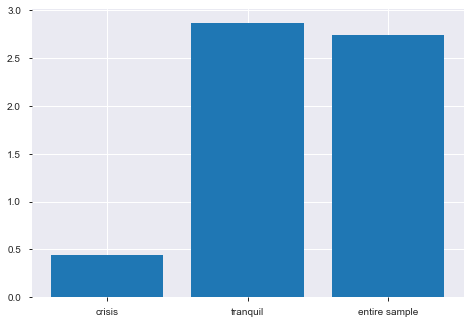

In [109]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
prob = [X3[X3["pred"] > 0.5]["exchange_change"].std(), X3[X3["pred"] < 0.5]["exchange_change"].shift(6).std(), X3["exchange_change"].shift(6).std()]
dummy = ["crisis","tranquil", "entire sample"]
ax.bar(dummy, prob)


In [1537]:
X3.to_csv("X3.csv")

In [943]:
from interpret.glassbox import ExplainableBoostingClassifier

X_train = X_train.fillna(X_train.mean())
ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, Y_train)

# EBM supports pandas dataframes, numpy arrays, and handles "string" data natively.

from interpret import show

ebm_global = ebm.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7406/2873379974672/ -->

In [501]:
X3[X3["Country_MY"] > 0]

,year,ENDE_XDC_USD_RATE,couprisk,broad_reserves_ratio,broad_base_ratio,foreignassets_reserves_ratio,inflation,current_account,moneymarket_rate,reseves,...,net_debt_level,lending_borrowing_level,lending_rate_level,M2_level,claims_private_level,yt2-1_level,threshold_level,pred,precrisis,dummy
2,1995-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,38.2,3.1,8.260000,0.025143,NaN,0.000978,0.051551,0.200272,0,0
63,1995-02-01,-0.0020,0.000017,NaN,NaN,NaN,-0.003358,NaN,-0.125446,-244.483552,...,NaN,NaN,8.310000,0.013188,NaN,-0.001367,0.051551,0.203110,0,0
106,1995-03-01,-0.0177,0.000009,NaN,NaN,NaN,0.002108,NaN,-0.013912,99.735386,...,NaN,NaN,8.470000,-0.011277,NaN,-0.000782,0.051551,0.212178,0,0
171,1995-04-01,-0.0653,0.000017,NaN,NaN,NaN,0.000000,NaN,0.090798,381.801464,...,NaN,NaN,8.600000,0.007825,NaN,-0.006929,0.051551,0.204844,0,0
207,1995-05-01,-0.0060,-0.000157,NaN,NaN,NaN,0.004997,NaN,0.122247,39.965026,...,NaN,NaN,8.680000,0.024249,NaN,-0.025741,0.051551,0.234222,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13452,2019-05-01,0.0615,-0.002028,-0.000019,-0.416476,-0.026428,0.000823,0.000000,-0.070142,-1132.861048,...,NaN,NaN,4.933569,0.000000,0.004755,0.013355,0.051551,0.006092,0,0
13502,2019-06-01,-0.0550,-0.000084,0.031129,0.275455,0.026935,0.012573,0.000000,-0.009882,314.431469,...,NaN,NaN,4.892962,0.000000,0.004964,0.014871,0.051551,0.003977,0,0
13546,2019-07-01,-0.0145,0.000009,-0.040601,0.101974,-0.005463,-0.000860,-0.481558,-0.002347,1165.175511,...,NaN,NaN,4.817469,0.000000,0.003136,-0.013105,0.051551,0.006641,0,0
13588,2019-08-01,0.0945,0.001543,-0.089951,-0.132717,-0.041741,0.000810,0.000000,-0.003106,-433.141483,...,NaN,NaN,4.822977,0.000000,0.001692,-0.003501,0.051551,0.007969,0,0


# MLP classifier

In [ ]:
full_fill2 = full_fill.loc["1995-01-01":"2019-12-31"]
full_fill3 = full_fill2
full_fill2 =  full_fill2[full_fill2.columns.drop(list(full_fill2.filter(regex='Country')))]
columns2 = columns.drop(list(full_fill.filter(regex='Country')))
#columns2 = ["inflation", "reserves_gdp", "commodities_growth", "couprisk", "ISO2 Code"]

X =  full_fill2[columns2].groupby("ISO2 Code").diff()

X_lag = full_fill2[columns2].groupby("ISO2 Code").diff().shift(1)
X_lag2 = full_fill2[columns2].groupby("ISO2 Code").diff().shift(2)
X_lag3 = full_fill2[columns2].groupby("ISO2 Code").diff().shift(3)
X_lag4 = full_fill2[columns2].groupby("ISO2 Code").diff().shift(4)
X_lag5 = full_fill2[columns2].groupby("ISO2 Code").diff().shift(5)

X_level = full_fill2[columns2].drop(["ISO2 Code"],1)

X_lag = X_lag.add_suffix('_lag')
X_lag2 = X_lag2.add_suffix('_lag2')
X_lag3 = X_lag3.add_suffix('_lag3')
X_lag4 = X_lag4.add_suffix('_lag4')
X_lag5 = X_lag5.add_suffix('_lag5')

X_level = X_level.add_suffix('_level')




Y = full_fill2['indicator2']
X = pd.concat((X, full_fill3.filter(regex='Country')), axis=1)
X = pd.concat([X, X_lag], axis=1)
#X = pd.concat([X, X_lag2], axis=1)
#X = pd.concat([X, X_lag3], axis=1)
#X = pd.concat([X, X_lag4], axis=1)
#X = pd.concat([X, X_lag5], axis=1)
X = pd.concat([X, X_level], axis=1)

X = X.fillna(X.mean())

#X = X.groupby('ISO2 Code_level').transform(lambda x: (x - x.mean()) / x.std())

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=X.columns, index = X.index)

X = X.sort_index() #For CV purpose
Y = Y.sort_index() #For CV purpose

X_train = X.loc["1990-01-01":"2009-12-31"]
X_test = X.loc["2010-01-01":"2019-12-31"]

Y_train = Y.loc["1990-01-01":"2009-12-31"]
Y_test = Y.loc["2010-01-01":"2019-12-31"]


In [510]:
from sklearn.model_selection import TimeSeriesSplit


#cv = GapWalkForward(n_splits=10, gap_size=6, test_size=48)

#sort by before
cv = TimeSeriesSplit(n_splits=4)


params = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive']}



clf2 = GridSearchCV(MLPClassifier(), params, n_jobs = -1, 
                   cv=cv, scoring= "balanced_accuracy",verbose=2, refit=True)



#clf =   XGBClassifier(n_estimators = 100,  eval_metric="auc")
#clf = LogisticRegression("l2", C = 0.1)
#clf = KNeighborsClassifier()
#clf = MLPClassifier()
#clf = ExtraTreesClassifier()
#clf.fit(X_train, Y_train)
clf2.fit(X_train, Y_train)
y_pred = clf2.predict(X_test)
y_prob = clf2.predict_proba(X_test)[:,1]
confusion_matrix(Y_test, y_pred)

Fitting 4 folds for each of 108 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed: 12.8min finished


array([[5034,  212],
       [ 171,   11]], dtype=int64)

In [511]:
lista = list(full_fill.filter(regex='Country'))
for iso in lista:

    full_fill2 = full_fill.loc["1995-01-01":"2019-12-31"]
    #full_fill2 = full_fill2.sort_index() #For CV purpose
    full_fill3 = full_fill2
    full_fill2 =  full_fill2[full_fill2.columns.drop(list(full_fill2.filter(regex='Country')))]
    columns2 = columns.drop(list(full_fill.filter(regex='Country')))
    #columns2 = ["inflation", "reserves_gdp", "commodities_growth", "couprisk", "ISO2 Code"]

    X =  full_fill2[columns2].groupby("ISO2 Code").diff()

    X_lag = full_fill2[columns2].groupby("ISO2 Code").diff().shift(1)
    X_lag2 = full_fill2[columns2].groupby("ISO2 Code").diff().shift(2)
    X_lag3 = full_fill2[columns2].groupby("ISO2 Code").diff().shift(3)
    X_lag4 = full_fill2[columns2].groupby("ISO2 Code").diff().shift(4)
    X_lag5 = full_fill2[columns2].groupby("ISO2 Code").diff().shift(5)

    X_level = full_fill2[columns2].drop(["ISO2 Code"],1)

    X_lag = X_lag.add_suffix('_lag')
    X_lag2 = X_lag2.add_suffix('_lag2')
    X_lag3 = X_lag3.add_suffix('_lag3')
    X_lag4 = X_lag4.add_suffix('_lag4')
    X_lag5 = X_lag5.add_suffix('_lag5')

    X_level = X_level.add_suffix('_level')




    Y = full_fill2['indicator2']
    X = pd.concat((X, full_fill3.filter(regex='Country')), axis=1)
    X = pd.concat([X, X_lag], axis=1)
    #X = pd.concat([X, X_lag2], axis=1)
    #X = pd.concat([X, X_lag3], axis=1)
    #X = pd.concat([X, X_lag4], axis=1)
    #X = pd.concat([X, X_lag5], axis=1)
    X = pd.concat([X, X_level], axis=1)

    X = X.fillna(X.mean())

    #X = X.groupby('ISO2 Code_level').transform(lambda x: (x - x.mean()) / x.std())

    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    scaler.fit(X)
    X = pd.DataFrame(scaler.transform(X), columns=X.columns, index = X.index)

    X = X.sort_index() #For CV purpose
    Y = Y.sort_index() #For CV purpose
    
    X_train = X.loc["1990-01-01":"2009-12-31"]
    X_test = X.loc["2010-01-01":"2019-12-31"]

    Y_train = Y.loc["1990-01-01":"2009-12-31"]
    Y_test = Y.loc["2010-01-01":"2019-12-31"]


    X3 = X 
    y_pred = clf2.predict(X3)
    y_prob = clf2.predict_proba(X3)[:,1]
    #confusion_matrix(Y_test, y_pred)

    X3["pred"] = y_prob
    X3["precrisis"] = Y

    currency2 = currency.copy()
    currency2 = currency2["ENDE_XDC_USD_RATE"]
    currency2 = currency2.reset_index()

    X3.reset_index(inplace=True)

    X3 = pd.concat([X3, currency2], 1)

    crisis = full_fill.sort_index().copy()
    crisis.reset_index(drop=True, inplace = True)
    crisis = crisis["dummy"]



    X3 = pd.concat([X3, crisis],1)



    X3.set_index("year")

    X2 = X3[X3[iso] > 0]

    X2["ENDE_XDC_USD_RATE"] = X2["ENDE_XDC_USD_RATE"].apply(pd.to_numeric, errors='coerce')
    X2["ENDE_XDC_USD_RATE"] = (X2["ENDE_XDC_USD_RATE"])/np.nanmax(X2["ENDE_XDC_USD_RATE"])
    #cycle, trend = sm.tsa.filters.hpfilter(X2["pred"], lamb=5)
    #X2["hp"] = trend
    #X2.plot(y= ["dummy","pred", "ENDE_XDC_USD_RATE"], linewidth=5, figsize=(15,15))




    import plotly.express as px
    import plotly.graph_objects as go

    X2.reset_index(inplace = True)

    fig = go.Figure()


    fig.add_trace(go.Bar(x=X2["year"],
                    y=X2["dummy"],
                    name='Crisis',
                    marker_color='rgb(264, 45, 45)',
                    width = 2678400000
                        ))

    fig.add_trace(go.Bar(x=X2["year"],
                    y=X2["precrisis"],
                    name='Precrisis',
                    marker_color='rgb(120, 120, 120)',
                    marker_line_color = 'rgb(128, 128, 128)',
                    opacity = 0.4,
                    width = 2678400000
                        ))

    fig.add_trace(go.Scatter(
                    x=X2["year"],
                    y=X2['pred'],
                    name="Prob",
                    line_color='deepskyblue',
                    opacity=1,
                    line=dict(color='deepskyblue', width=4
                                  )))

    fig.add_trace(go.Scatter(
                    x=X2["year"],
                    y=X2["ENDE_XDC_USD_RATE"],
                    name="Exchange Rate",
                    line_color='dimgray',
                    opacity=0.6,
                    line=dict(color='firebrick', width=4)))


    fig.update_layout(
        autosize=False,
        width=1000,
        height=600)

    fig.write_image(iso + "_graph_xgb_NN.png")

C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

#Logit

In [491]:
full_fill2 = full_fill.loc["1995-01-01":"2019-12-31"]
full_fill3 = full_fill2
full_fill2 =  full_fill2[full_fill2.columns.drop(list(full_fill2.filter(regex='Country')))]
columns2 = columns.drop(list(full_fill.filter(regex='Country')))
#columns2 = ["inflation", "reserves_gdp", "commodities_growth", "couprisk", "ISO2 Code"]

X =  full_fill2[columns2].groupby("ISO2 Code").diff()

X_lag = full_fill2[columns2].groupby("ISO2 Code").diff().shift(1)
X_lag2 = full_fill2[columns2].groupby("ISO2 Code").diff().shift(2)
X_lag3 = full_fill2[columns2].groupby("ISO2 Code").diff().shift(3)
X_lag4 = full_fill2[columns2].groupby("ISO2 Code").diff().shift(4)
X_lag5 = full_fill2[columns2].groupby("ISO2 Code").diff().shift(5)

X_level = full_fill2[columns2].drop(["ISO2 Code"],1)

X_lag = X_lag.add_suffix('_lag')
X_lag2 = X_lag2.add_suffix('_lag2')
X_lag3 = X_lag3.add_suffix('_lag3')
X_lag4 = X_lag4.add_suffix('_lag4')
X_lag5 = X_lag5.add_suffix('_lag5')

X_level = X_level.add_suffix('_level')




Y = full_fill2['indicator2']
X = pd.concat((X, full_fill3.filter(regex='Country')), axis=1)
X = pd.concat([X, X_lag], axis=1)
#X = pd.concat([X, X_lag2], axis=1)
#X = pd.concat([X, X_lag3], axis=1)
#X = pd.concat([X, X_lag4], axis=1)
#X = pd.concat([X, X_lag5], axis=1)
X = pd.concat([X, X_level], axis=1)

X = X.fillna(X.mean())

#X = X.groupby('ISO2 Code_level').transform(lambda x: (x - x.mean()) / x.std())

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=X.columns, index = X.index)

X = X.sort_index() #For CV purpose
Y = Y.sort_index() #For CV purpose

X_train = X.loc["1990-01-01":"2009-12-31"]
X_test = X.loc["2010-01-01":"2019-12-31"]

Y_train = Y.loc["1990-01-01":"2009-12-31"]
Y_test = Y.loc["2010-01-01":"2019-12-31"]

In [494]:
from sklearn.model_selection import TimeSeriesSplit


#cv = GapWalkForward(n_splits=10, gap_size=6, test_size=48)

#sort by before
cv = TimeSeriesSplit(n_splits=10)




# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
params = dict(C=C, penalty=penalty)

clf3 = GridSearchCV(LogisticRegression(), params, n_jobs = -1, 
                   cv=cv, scoring= "f1",verbose=2, refit=True)



#clf =   XGBClassifier(n_estimators = 100,  eval_metric="auc")
#clf = LogisticRegression("l2", C = 0.1)
#clf = KNeighborsClassifier()
#clf = MLPClassifier()
#clf = ExtraTreesClassifier()
#clf.fit(X_train, Y_train)
clf3.fit(X_train, Y_train)
y_pred = clf3.predict(X_test)
y_prob = clf3.predict_proba(X_test)[:,1]
confusion_matrix(Y_test, y_pred)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.4min finished
C:\Users\vitor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



array([[5122,  124],
       [ 168,   14]], dtype=int64)

In [495]:
lista = list(full_fill.filter(regex='Country'))
for iso in lista:

    full_fill2 = full_fill.loc["1995-01-01":"2019-12-31"]
    #full_fill2 = full_fill2.sort_index() #For CV purpose
    full_fill3 = full_fill2
    full_fill2 =  full_fill2[full_fill2.columns.drop(list(full_fill2.filter(regex='Country')))]
    columns2 = columns.drop(list(full_fill.filter(regex='Country')))
    #columns2 = ["inflation", "reserves_gdp", "commodities_growth", "couprisk", "ISO2 Code"]

    X =  full_fill2[columns2].groupby("ISO2 Code").diff()

    X_lag = full_fill2[columns2].groupby("ISO2 Code").diff().shift(1)
    X_lag2 = full_fill2[columns2].groupby("ISO2 Code").diff().shift(2)
    X_lag3 = full_fill2[columns2].groupby("ISO2 Code").diff().shift(3)
    X_lag4 = full_fill2[columns2].groupby("ISO2 Code").diff().shift(4)
    X_lag5 = full_fill2[columns2].groupby("ISO2 Code").diff().shift(5)

    X_level = full_fill2[columns2].drop(["ISO2 Code"],1)

    X_lag = X_lag.add_suffix('_lag')
    X_lag2 = X_lag2.add_suffix('_lag2')
    X_lag3 = X_lag3.add_suffix('_lag3')
    X_lag4 = X_lag4.add_suffix('_lag4')
    X_lag5 = X_lag5.add_suffix('_lag5')

    X_level = X_level.add_suffix('_level')




    Y = full_fill2['indicator2']
    X = pd.concat((X, full_fill3.filter(regex='Country')), axis=1)
    X = pd.concat([X, X_lag], axis=1)
    #X = pd.concat([X, X_lag2], axis=1)
    #X = pd.concat([X, X_lag3], axis=1)
    #X = pd.concat([X, X_lag4], axis=1)
    #X = pd.concat([X, X_lag5], axis=1)
    X = pd.concat([X, X_level], axis=1)

    X = X.fillna(X.mean())

    #X = X.groupby('ISO2 Code_level').transform(lambda x: (x - x.mean()) / x.std())

    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    scaler.fit(X)
    X = pd.DataFrame(scaler.transform(X), columns=X.columns, index = X.index)

    X = X.sort_index() #For CV purpose
    Y = Y.sort_index() #For CV purpose
    
    X_train = X.loc["1990-01-01":"2009-12-31"]
    X_test = X.loc["2010-01-01":"2019-12-31"]

    Y_train = Y.loc["1990-01-01":"2009-12-31"]
    Y_test = Y.loc["2010-01-01":"2019-12-31"]


    X3 = X 
    y_pred = clf3.predict(X3)
    y_prob = clf3.predict_proba(X3)[:,1]
    #confusion_matrix(Y_test, y_pred)

    X3["pred"] = y_prob
    X3["precrisis"] = Y

    currency2 = currency.copy()
    currency2 = currency2["ENDE_XDC_USD_RATE"]
    currency2 = currency2.reset_index()

    X3.reset_index(inplace=True)

    X3 = pd.concat([X3, currency2], 1)

    crisis = full_fill.sort_index().copy()
    crisis.reset_index(drop=True, inplace = True)
    crisis = crisis["dummy"]



    X3 = pd.concat([X3, crisis],1)



    X3.set_index("year")

    X2 = X3[X3[iso] > 0]

    X2["ENDE_XDC_USD_RATE"] = X2["ENDE_XDC_USD_RATE"].apply(pd.to_numeric, errors='coerce')
    X2["ENDE_XDC_USD_RATE"] = (X2["ENDE_XDC_USD_RATE"])/np.nanmax(X2["ENDE_XDC_USD_RATE"])
    #cycle, trend = sm.tsa.filters.hpfilter(X2["pred"], lamb=5)
    #X2["hp"] = trend
    #X2.plot(y= ["dummy","pred", "ENDE_XDC_USD_RATE"], linewidth=5, figsize=(15,15))




    import plotly.express as px
    import plotly.graph_objects as go

    X2.reset_index(inplace = True)

    fig = go.Figure()


    fig.add_trace(go.Bar(x=X2["year"],
                    y=X2["dummy"],
                    name='Crisis',
                    marker_color='rgb(264, 45, 45)',
                    width = 2678400000
                        ))

    fig.add_trace(go.Bar(x=X2["year"],
                    y=X2["precrisis"],
                    name='Precrisis',
                    marker_color='rgb(120, 120, 120)',
                    marker_line_color = 'rgb(128, 128, 128)',
                    opacity = 0.4,
                    width = 2678400000
                        ))

    fig.add_trace(go.Scatter(
                    x=X2["year"],
                    y=X2['pred'],
                    name="Prob",
                    line_color='deepskyblue',
                    opacity=1,
                    line=dict(color='deepskyblue', width=4
                                  )))

    fig.add_trace(go.Scatter(
                    x=X2["year"],
                    y=X2["ENDE_XDC_USD_RATE"],
                    name="Exchange Rate",
                    line_color='dimgray',
                    opacity=0.6,
                    line=dict(color='firebrick', width=4)))


    fig.update_layout(
        autosize=False,
        width=1000,
        height=600)

    fig.write_image(iso + "_graph_logit.png")

C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

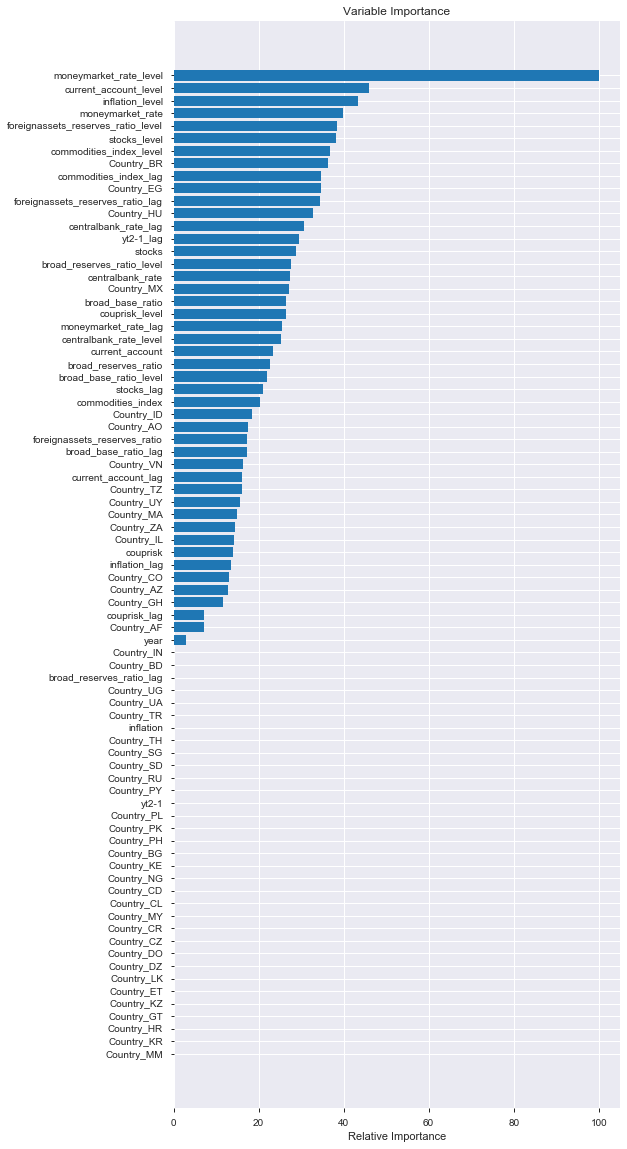

<Figure size 7200x10800 with 0 Axes>

In [172]:

import matplotlib.pyplot as plt

# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(8, 20))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.figure(figsize=(100,150))
plt.show()

In [299]:
import pandas_profiling

profile = X_final.profile_report(title = "Profile")
profile.to_file(output_file = "output.html")